In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import os
from tqdm import tqdm
import time

# *Fun*-ctions

In [9]:
def hdf_to_df(hdf5_file_path: str) -> None:
    """
    """
    with pd.HDFStore(hdf5_file_path, mode='r') as store:
        available_keys = store.keys()
        for key in available_keys:
            if "w" in key or "v_inner" in key:
                key = key.split("/model/")[0]
                yield key


In [11]:
def interpolate_to_length(data, length):
    old_indices = np.arange(len(data))
    new_indices = np.linspace(0, len(data)-1, length)
    return np.interp(new_indices, old_indices, data)

In [14]:
def read_in_data(hdf5_file_path, key):
    
    v_inner = pd.read_hdf(hdf5_file_path, key=f'{key}/model/v_inner')
    v_outer = pd.read_hdf(hdf5_file_path, key = f'{key}/model/v_outer')
    w_data = pd.read_hdf(hdf5_file_path, key=f'{key}/model/w')
    
    return v_inner, v_outer, w_data
    
    

In [16]:
def interpolate_data(hdf5_file_path: str, n_elem: int, key: str) -> pd.DataFrame:
    """
    """
    v_inner = pd.read_hdf(hdf5_file_path, key=f'{key}/model/v_inner').to_numpy()
    v_outer = pd.read_hdf(hdf5_file_path, key = f'{key}/model/v_outer').to_numpy()
    w_data = pd.read_hdf(hdf5_file_path, key=f'{key}/model/w').to_numpy()

    
    v_inner_interp = interpolate_to_length(v_inner, n_elem)
    v_outer_interp = interpolate_to_length(v_outer, n_elem)
    w_interp = interpolate_to_length(w_data, 40)
    
    dv = (v_outer_interp -v_inner_interp)[:-1]
    
    v = np.concatenate((v_inner[:1], dv)) #revert back to v_inner using np.cumsum on v

    col_names_v = [f'v_{i+1}' for i in range(len(v))]
    col_names_w = [f'w_{i+1}' for i in range(len(w_interp))]

    df_v = pd.DataFrame(v).T
    df_w = pd.DataFrame(w_interp).T

    df_v.columns = col_names_v
    df_w.columns = col_names_w

    df = pd.concat([df_v, df_w], axis=1)

    return df


In [5]:
def process_data(hdf5_file_path: str, n_elem: int) -> pd.DataFrame:
    """
    """
    keys = list(hdf_to_df(hdf5_file_path))

    keys = list(dict.fromkeys(keys))

    result_df = pd.DataFrame()
    
    for key in keys:
        df = interpolate_data(hdf5_file_path, n_elem, key)
        result_df = pd.concat([result_df, df], ignore_index=True)
    
    return result_df


# Extracting tar files

In [5]:
#import tarfile

#file_path = "../../data/emulator/hdf5-1.14.1-2-Std-centos8_64.tar.gz"

#destination_folder = "../../"

#with tarfile.open(file_path, "r:gz") as tar:
#    tar.extractall(path=destination_folder)


# Combine and Export data to Feather

In [28]:
def hdf_to_df(hdf5_file_path: str) -> None:
    with pd.HDFStore(hdf5_file_path, mode='r') as store:
        available_keys = store.keys()
        for key in available_keys:
            if "w" in key or "v_inner" in key:
                yield key.split("/model/")[0]


In [29]:
keys = list(hdf_to_df(file_path + list_of_sims[0] ))

In [33]:
list_of_sims = os.listdir("../../data/emulator/mnt/gs21/scratch/obrie278/Outputs/2022Emulator/Simulations/")
file_path = '../../data/emulator/mnt/gs21/scratch/obrie278/Outputs/2022Emulator/Simulations/'


def process_file(hdf5_file):
    hdf5_file_path = file_path + hdf5_file
    keys = list(hdf_to_df(hdf5_file_path ))
    return [read_in_data(hdf5_file_path, key) for key in keys]
%timeit len(process_file(list_of_sims[0]))


6.96 s ± 339 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
len(list_of_sims) * 6.96/60

116.0

In [30]:
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

list_of_sims = os.listdir("../../data/emulator/mnt/gs21/scratch/obrie278/Outputs/2022Emulator/Simulations/")
file_path = '../../data/emulator/mnt/gs21/scratch/obrie278/Outputs/2022Emulator/Simulations/'

def process_file(hdf5_file):
    hdf5_file_path = file_path + hdf5_file
    return process_data(hdf5_file_path, 40)

max_threads = 6
dataframes = []  

with ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = [executor.submit(process_file, hdf5_file) for hdf5_file in list_of_sims]
    for future in tqdm(as_completed(futures), total=len(list_of_sims), desc="Processing Data", unit="file"):
        df_temp = future.result()
        dataframes.append(df_temp) 

df = pd.concat(dataframes) 

Processing Data: 100%|█████████████████████████████████████████████████████████| 1000/1000 [1:12:20<00:00,  4.34s/file]


In [38]:
df.reset_index()

,index,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40
0,0,1.443119e+09,1.230241e+07,3.580028e+07,5.248197e+07,5.358383e+07,5.470972e+07,5.585106e+07,5.702974e+07,5.822118e+07,...,0.106668,0.103144,0.099819,0.096413,0.093012,0.089911,0.086863,0.083897,0.081009,0.078155
1,1,1.273128e+09,1.481055e+07,3.194642e+07,4.192044e+07,4.277939e+07,4.366271e+07,4.455851e+07,4.547376e+07,4.641145e+07,...,0.239514,0.230244,0.221647,0.213360,0.205520,0.197961,0.190609,0.183795,0.177177,0.170712
2,2,1.294317e+09,8.739798e+06,3.075082e+07,4.347865e+07,4.439151e+07,4.533092e+07,4.628393e+07,4.725814e+07,4.825683e+07,...,0.090599,0.086867,0.083654,0.080591,0.077591,0.074747,0.072003,0.069456,0.066967,0.064525
3,3,1.230407e+09,4.482057e+06,3.041063e+07,4.248213e+07,4.347170e+07,4.449104e+07,4.553344e+07,4.659534e+07,4.768508e+07,...,0.182205,0.175015,0.168200,0.161533,0.155113,0.148809,0.142597,0.136756,0.131203,0.125950
4,4,1.168180e+09,3.679483e+06,2.068325e+07,3.042495e+07,3.092403e+07,3.143443e+07,3.195059e+07,3.247573e+07,3.301115e+07,...,0.117543,0.113594,0.109825,0.106189,0.102830,0.099594,0.096430,0.093361,0.090402,0.087527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233924,175,1.145226e+09,2.019068e+07,3.532901e+07,4.123646e+07,4.229688e+07,4.338248e+07,4.450455e+07,4.565218e+07,4.682579e+07,...,0.134573,0.128429,0.122767,0.117608,0.112739,0.108036,0.103525,0.099254,0.095228,0.091462
233925,176,8.562695e+08,2.925810e+07,3.043147e+07,3.143735e+07,3.246424e+07,3.352459e+07,3.461946e+07,3.574999e+07,3.691732e+07,...,0.110324,0.103343,0.097205,0.091929,0.086887,0.082052,0.077639,0.073486,0.069644,0.065973
233926,177,1.023729e+09,1.048212e+07,2.956088e+07,3.443972e+07,3.535914e+07,3.630191e+07,3.726856e+07,3.826268e+07,3.928619e+07,...,0.054064,0.051453,0.049009,0.046671,0.044515,0.042462,0.040495,0.038592,0.036760,0.035051
233927,178,8.030305e+08,1.594077e+07,1.942119e+07,1.988175e+07,2.035323e+07,2.083588e+07,2.132999e+07,2.183581e+07,2.235363e+07,...,0.129214,0.123674,0.118847,0.113717,0.108685,0.104648,0.100455,0.096008,0.091588,0.088062


In [40]:
df.reset_index().to_feather("../../data/full_data.feather")

In [41]:
pd.read_feather("../../data/full_data.feather")

,index,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40
0,0,1.443119e+09,1.230241e+07,3.580028e+07,5.248197e+07,5.358383e+07,5.470972e+07,5.585106e+07,5.702974e+07,5.822118e+07,...,0.106668,0.103144,0.099819,0.096413,0.093012,0.089911,0.086863,0.083897,0.081009,0.078155
1,1,1.273128e+09,1.481055e+07,3.194642e+07,4.192044e+07,4.277939e+07,4.366271e+07,4.455851e+07,4.547376e+07,4.641145e+07,...,0.239514,0.230244,0.221647,0.213360,0.205520,0.197961,0.190609,0.183795,0.177177,0.170712
2,2,1.294317e+09,8.739798e+06,3.075082e+07,4.347865e+07,4.439151e+07,4.533092e+07,4.628393e+07,4.725814e+07,4.825683e+07,...,0.090599,0.086867,0.083654,0.080591,0.077591,0.074747,0.072003,0.069456,0.066967,0.064525
3,3,1.230407e+09,4.482057e+06,3.041063e+07,4.248213e+07,4.347170e+07,4.449104e+07,4.553344e+07,4.659534e+07,4.768508e+07,...,0.182205,0.175015,0.168200,0.161533,0.155113,0.148809,0.142597,0.136756,0.131203,0.125950
4,4,1.168180e+09,3.679483e+06,2.068325e+07,3.042495e+07,3.092403e+07,3.143443e+07,3.195059e+07,3.247573e+07,3.301115e+07,...,0.117543,0.113594,0.109825,0.106189,0.102830,0.099594,0.096430,0.093361,0.090402,0.087527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233924,175,1.145226e+09,2.019068e+07,3.532901e+07,4.123646e+07,4.229688e+07,4.338248e+07,4.450455e+07,4.565218e+07,4.682579e+07,...,0.134573,0.128429,0.122767,0.117608,0.112739,0.108036,0.103525,0.099254,0.095228,0.091462
233925,176,8.562695e+08,2.925810e+07,3.043147e+07,3.143735e+07,3.246424e+07,3.352459e+07,3.461946e+07,3.574999e+07,3.691732e+07,...,0.110324,0.103343,0.097205,0.091929,0.086887,0.082052,0.077639,0.073486,0.069644,0.065973
233926,177,1.023729e+09,1.048212e+07,2.956088e+07,3.443972e+07,3.535914e+07,3.630191e+07,3.726856e+07,3.826268e+07,3.928619e+07,...,0.054064,0.051453,0.049009,0.046671,0.044515,0.042462,0.040495,0.038592,0.036760,0.035051
233927,178,8.030305e+08,1.594077e+07,1.942119e+07,1.988175e+07,2.035323e+07,2.083588e+07,2.132999e+07,2.183581e+07,2.235363e+07,...,0.129214,0.123674,0.118847,0.113717,0.108685,0.104648,0.100455,0.096008,0.091588,0.088062


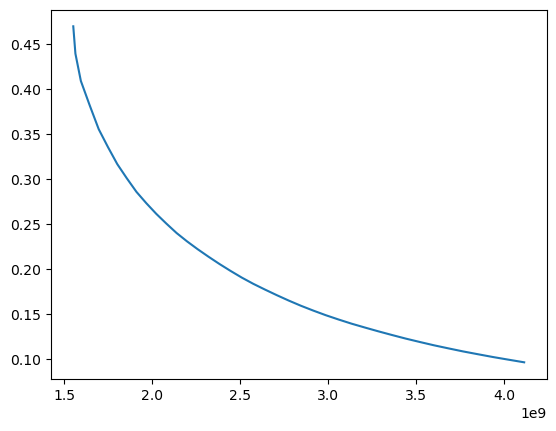

In [26]:
plt.plot(np.cumsum(df.iloc[0,:40]), df.iloc[0,40:]) # row 20 is a bit odd... not sure if that is right